## Convirtiendo un pdf en markdown

If you want begin with a more simple example [pdf2images.ipynb]("./pdf2images.ipynb")

## pdf to markdowns

* Define your Documents and Transformers

In [2]:
# Install pdf2image for this example
# !pip install pdf2image

In [3]:
from document_transformer import Document, DocumentTransformer
from typing import List
from pathlib import Path
import pdf2image

class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class MarkdownDocument(Document):
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

class PDF2Images(DocumentTransformer):
    input: PDFDocument = None
    output: List[ImageDocument] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        return [
            ImageDocument(
                metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                data=image,
            )
            for i, image in enumerate(images)
        ]

* Define the `Image2Markdown` transformer, which takes an `ImageDocument` and transforms it into a `MarkdownDocument`.
* To keep things simple, we'll define an OCR method with dummy data. However, it's important that you implement your own OCR logic here.

In [4]:
class Image2Markdown(DocumentTransformer):
    input: ImageDocument = None
    output: MarkdownDocument = None

    def ocr(self):
        """ocr, puede ser una función externa"""
        return f"OCR {self.input.metadata['page']}"

    def transformer(self):
        ocr_text = self.ocr()
        return MarkdownDocument(
            metadata={'image_path': self.input.path, 'page': self.input.metadata['page']},
            data=ocr_text
        )

run it!

In [5]:
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

for image in images:
    image.save(path=f'images/pag_{image.metadata["page"]}.jpg')
    markdown = Image2Markdown(input=image).run()
    markdown.save(path=f'images/pag_{image.metadata["page"]}.md')
    print(markdown)

id='68859ec0-9b90-4442-9b27-2dc68ef190ac' path='images/pag_1.md' data='OCR 1' metadata={'image_path': 'images/pag_1.jpg', 'page': 1} parents={'17126b9f-f886-4d82-9775-bb6506b985c3'} childrens=set()
id='ddb765f5-d54f-4792-b876-671032da6f27' path='images/pag_2.md' data='OCR 2' metadata={'image_path': 'images/pag_2.jpg', 'page': 2} parents={'e9da44ad-8de0-41d4-b3a5-fc858ea12637'} childrens=set()
id='c225811f-281e-4203-a5e3-fa6621102e6e' path='images/pag_3.md' data='OCR 3' metadata={'image_path': 'images/pag_3.jpg', 'page': 3} parents={'544731e1-8eaa-47fb-a2d5-91b618651c70'} childrens=set()


Now the diversion! Use your document transformer

In [6]:
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

for image in images:
    image.save(path=f'images/pag_{image.metadata["page"]}.jpg')
    print(f"Imagen: {image.id}")
    print(f"Parents: {image.parents}")
    print(f"Metadata: {image.metadata}")

Imagen: 1715c73a-788e-469d-bd5d-e866a680ad88
Parents: {'ad14d44a-e50f-41f6-8d60-ae665a89c98c'}
Metadata: {'pdf_path': 'document.pdf', 'page': 1, 'size': (1700, 2200)}
Imagen: 2fbca010-62ab-4ca5-8642-affb352944f9
Parents: {'ad14d44a-e50f-41f6-8d60-ae665a89c98c'}
Metadata: {'pdf_path': 'document.pdf', 'page': 2, 'size': (1700, 2200)}
Imagen: 44233210-4b04-4124-9449-03399052d3b5
Parents: {'ad14d44a-e50f-41f6-8d60-ae665a89c98c'}
Metadata: {'pdf_path': 'document.pdf', 'page': 3, 'size': (1700, 2200)}


* If you prefier, you can define a `Pipeline`.
* In a list insert each transformer  and plot it!

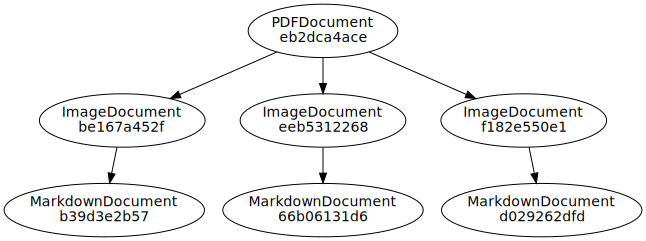

In [7]:
from document_transformer import Pipeline
from document_transformer.utils import plot_graph

pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[PDF2Images(), Image2Markdown()])
markdowns = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

All is ok?
Save only markdowns!

In [8]:
for markdown in markdowns:
    markdown.save(path=f'images/pag_{markdown.metadata["page"]}.md')

But if you prefer, you can instruct from Pipeline directly!

In [9]:
pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[
    PDF2Images(),
    Image2Markdown(to='images/pag_{metadata[page]}.md')
])

pipeline.run(input=pdf_doc)

[MarkdownDocument(id='32e9811c-4599-4827-a25b-ba16bdb66c1b', path='images/pag_1.md', data='OCR 1', metadata={'image_path': None, 'page': 1}, parents={'08bba755-a5a1-4a79-a4f6-948877683c6d'}, childrens=set()),
 MarkdownDocument(id='bd0f35cf-3e58-4851-ae11-6f796cc581e8', path='images/pag_2.md', data='OCR 2', metadata={'image_path': None, 'page': 2}, parents={'36512aab-f79f-4e53-aaa9-6b63b6fb5eec'}, childrens=set()),
 MarkdownDocument(id='d026f0f4-251c-4256-b1a0-6338107d4825', path='images/pag_3.md', data='OCR 3', metadata={'image_path': None, 'page': 3}, parents={'38820ddf-a93e-4fd3-96e8-88db953e5833'}, childrens=set())]

## Combine markdowns

Now, we are going to merge the markdowns. For that we need to increase the skills of `MarkdownDocument`. Let me define the `appender` method.

In [10]:
class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self


That is all, now we can to append each markdown document to another

In [12]:
# create images
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

# Initialize the markdown document
markdown_doc = MarkdownDocument()
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdown_doc.append(markdown)

markdown_doc.save(path="document.md")

MarkdownDocument(id='7ff30070-c4f5-4f92-90ae-86722414d486', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'e964cee7-32f6-4812-8c7d-4e9839b59cf4', 'ee3dcd9d-f7b0-4d1f-b675-0168110be275', 'ea955275-3588-425d-a5ab-7cbee31692a4'}, childrens=set())

The library supports initializing an empty list and combining markdown documents at the end


In [13]:

pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

# initialize an empty list of markdowns
markdowns = []
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdowns.append(markdown)

# Combine them into a single markdown document and save it
markdown_doc = MarkdownDocument().extend(markdowns)
markdown_doc.save(path="document.md")

MarkdownDocument(id='b7d6f86f-4653-4a74-9c59-2c1e59a746cf', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'206aa47c-45d6-4143-8408-b4b3624314cd', '0d4e156e-d9f8-4c77-a574-6016d470c83b', '5038ff5a-0bf9-4bc7-a116-ad90bc7ac967'}, childrens=set())

Alternatively, you can always create a `DocumentTransformer` class to handle this task


In [14]:
class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)

pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

markdowns = []
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdowns.append(markdown)

markdown_doc = CombineMarkdowns(input=markdowns).run()
markdown_doc.save(path="document.md")

MarkdownDocument(id='fe6297fc-02e8-468e-bf16-768804c2bba1', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'ab40a7dd-e19d-4051-912e-ad043643d45d', 'a10cbf76-9a43-432a-8069-68b5a645eee5', 'b7d87452-4123-423a-85f4-eedc6295ef3c'}, childrens=set())

Which brings a reward! Now you can extend your Pipeline

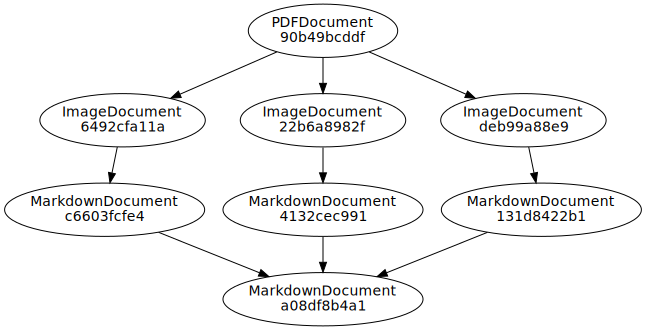

In [15]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Images(), Image2Markdown(), CombineMarkdowns()
])

# Run and visualize it!
pdf_doc = PDFDocument(path="document.pdf")
markdown_doc = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

In [16]:
pipeline.get_traces()

[{'id': 'd87432d6-7c36-4ba8-8a03-5790b49bcddf',
  'path': 'document.pdf',
  'type': 'PDFDocument',
  'childrens': ['a08c960a-9a6b-4be5-aaed-b46492cfa11a',
   'a65893bd-eee8-4bbc-89cc-0e22b6a8982f',
   '2276aa40-507e-433f-9dee-24deb99a88e9'],
  'parents': []},
 {'id': 'a08c960a-9a6b-4be5-aaed-b46492cfa11a',
  'path': None,
  'type': 'ImageDocument',
  'childrens': ['0b6a1bad-9b27-488b-a36c-b0c6603fcfe4'],
  'parents': ['d87432d6-7c36-4ba8-8a03-5790b49bcddf']},
 {'id': 'a65893bd-eee8-4bbc-89cc-0e22b6a8982f',
  'path': None,
  'type': 'ImageDocument',
  'childrens': ['a83fde9a-dfe3-4f74-a854-0a4132cec991'],
  'parents': ['d87432d6-7c36-4ba8-8a03-5790b49bcddf']},
 {'id': '2276aa40-507e-433f-9dee-24deb99a88e9',
  'path': None,
  'type': 'ImageDocument',
  'childrens': ['9434975f-b676-4478-bcb2-b7131d8422b1'],
  'parents': ['d87432d6-7c36-4ba8-8a03-5790b49bcddf']},
 {'id': '0b6a1bad-9b27-488b-a36c-b0c6603fcfe4',
  'path': None,
  'type': 'MarkdownDocument',
  'childrens': ['49be0108-aa96-45d

Remember, if you need to save each part, you can specify it in the Pipeline


In [17]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Images(to='images/pag_{metadata[page]}.jpg'),
    Image2Markdown(to='images/pag_{metadata[page]}.md'),
    CombineMarkdowns(to='document.md')
])

# Run it!
pdf_doc = PDFDocument(path="document.pdf")
pipeline.run(input=pdf_doc)

MarkdownDocument(id='c2b68e35-01c5-438f-ab92-71c7dd183613', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents={'24d36bda-09a7-4968-9b77-970f7ff2bd47', '037bd089-e653-4e96-852b-01d9e643729c', '15bc9495-e8d2-4862-92b9-62ccf174a499'}, childrens=set())

## All togheter!

Next all definitions and final Pipeline. Insert more than one input document if you need it!

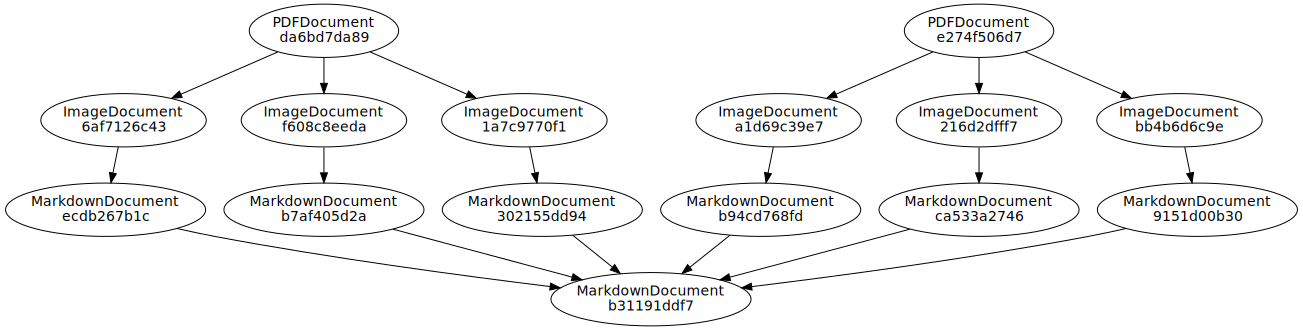

In [18]:
from document_transformer import Document, DocumentTransformer
from document_transformer.utils import plot_graph
from typing import List
from pathlib import Path
import pdf2image

######################################################
# Documents
######################################################
class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self

######################################################
# Transfomers
######################################################
class PDF2Images(DocumentTransformer):
    input: PDFDocument = None
    output: List[ImageDocument] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        return [
            ImageDocument(
                metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                data=image,
            )
            for i, image in enumerate(images)
        ]

class Image2Markdown(DocumentTransformer):
    input: ImageDocument = None
    output: MarkdownDocument = None

    def ocr(self):
        """ocr, puede ser una función externa"""
        return f"OCR {self.input.metadata['page']}"

    def transformer(self):
        ocr_text = self.ocr()
        return MarkdownDocument(
            metadata={'image_path': self.input.path, 'page': self.input.metadata['page']},
            data=ocr_text
        )

class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)
    

######################################################
# Pipeline
######################################################
pipeline = Pipeline(transformers=[
    PDF2Images(to='images/pag_{metadata[page]}.jpg'),
    Image2Markdown(to='images/pag_{metadata[page]}.md'),
    CombineMarkdowns(to='document.md')
])

# Run it!
pdf_doc1 = PDFDocument(path="document.pdf")
pdf_doc2 = PDFDocument(path="document.pdf")

markdown_doc = pipeline.run(input=[pdf_doc1, pdf_doc2])
plot_graph(pipeline.get_traces())

## Conclusions

As you can see, `document-transformer` is your friend when it comes to organizing your transformer pipeline. Simply define your components, and `document-transformer` will handle the rest, ensuring traceability and organization. Reuse your work in any project!